In [17]:
# Make division and print() behave like Python 3 even if 
# using Python 2.x:
from __future__ import print_function, division

# Import the key packages we need:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# Make default font a bit bigger:
import matplotlib
matplotlib.rcParams['font.size'] = 18   # Font size in points

from astropy.table import Table
from astropy.constants import iau2015 as const
from astropy import units as u
from astropy.time import Time

import uncertainties as unc  
import uncertainties.unumpy as unumpy

import orbits

# Plots show in the notebook, not pop-up:
%matplotlib inline


29.900881337122712


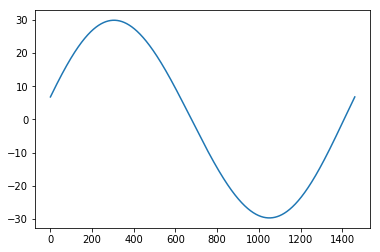

In [18]:
#Quantities of earth orbit viewed from a specific position
d_pc = 10 #pc
parallax = 1/d_pc

P = 1 #yr
e = 0.01671022
T = 1 #yr
a_AU = 1.00000011 #AU
a_arcsec = orbits.au2arcsec(a_AU, d_pc)
i = np.deg2rad(90) #deg
w = np.deg2rad(102.94719) #deg
Omega = np.deg2rad(-11.26064) #deg

A, B, F, G, C, H = orbits.Thiele_Innes_from_Campbell(w, a_arcsec, i, Omega, parallax=parallax)

num_obs = 1461

times = P*np.arange(num_obs)/(num_obs - 1)

ra, dec, radvel = orbits.keplerian_xy_Thiele_Innes(times, A, B, F, G, T, e, P, C=C, H=H)

radvel_km_sec = radvel*(149600000000/1000)/(365.256*24*60*60)
print(np.max(radvel_km_sec))

plt.plot(radvel_km_sec)
plt.show()

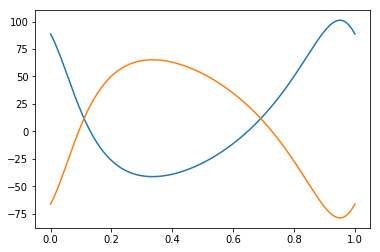

In [19]:
#Eq.8 L14
#HD 224355
#Lester et al. 2019
P_d = 12.156160
P_yr = P_d/365.256
T0 = 53282.3198 + 2.4e6
T0 = Time(T0, format='jd')
T0 = T0.jyear
e = 0.3117
a = 0.002392
i = np.radians(97.1)
w = np.radians(34.46)
Omega = np.radians(219.4)

k1 = 71.11
lit_sigma_k1 = 0.03

k2 = 71.90
lit_sigma_k2 = 0.03

lit_gamma = 11.74
lit_sigma_gamma = 0.01

rat1 = k1/(k1+k2)
rat2 = k2/(k1+k2)

d_pc = 63.98
parallax = 1/d_pc

A, B, F, G, C, H = orbits.Thiele_Innes_from_Campbell(w, a, i, Omega, parallax=parallax)

num_obs = 1461
times = P_yr*np.arange(num_obs)/(num_obs-1)
    
ra_theo, dec_theo, radvel_theo = orbits.keplerian_xy_Thiele_Innes(times, A, B, F, G, 0, e, P_yr, C=C, H=H)
radvel_km_sec = orbits.AUyr2Kms(radvel_theo)

radvel1 = rat1*radvel_km_sec
radvel2 = rat2*radvel_km_sec

Phase = times/P_yr

plt.plot(Phase, -radvel1+lit_gamma)
plt.plot(Phase, radvel2+lit_gamma)
plt.show()

Gamma from orbits routine: 12.021 +- 0.059
K1 from orbits routine: 71.142 +- 0.095
K2 from orbits routine: 71.494 +- 0.108


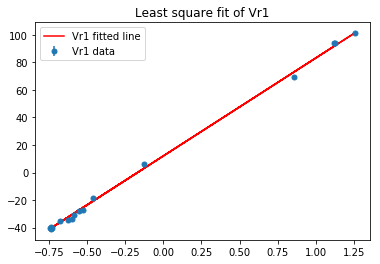

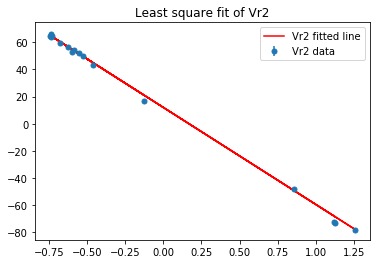

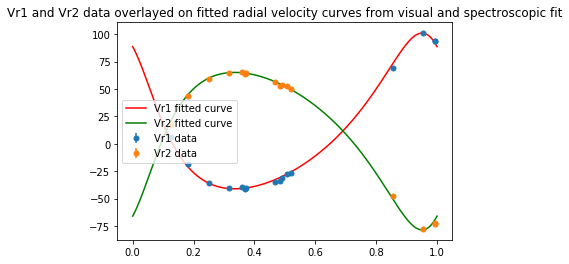

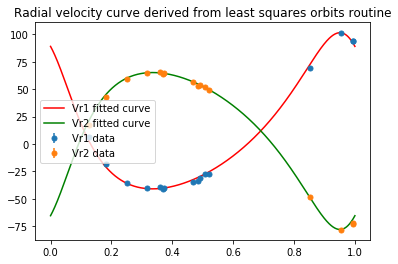

Fitted gamma sigma: 0.059
Paper gamma sigma: 0.010

Fitted k1 sigma: 0.095
Paper k1 sigma: 0.030

Fitted k2 sigma: 0.108
Paper k2 sigma: 0.030


In [20]:
def v_fraction(times, P, T, e, w):
    
    M = (2*np.pi/P)*(times-T)
    E = orbits.getE_parallel(M, e)
    v_frac = (np.cos(w)*np.cos(E)*(1-e**2)-np.sin(w)*np.sin(E)*np.sqrt(1-e**2))/(1-e*np.cos(E))
    return v_frac

#Sigma HD 244355
#Lester et al. 2019
P_d = 12.156160
P_yr = P_d/365.256
T0 = 53282.3198 + 2.4e6
T0 = Time(T0, format='jd')
T0 = T0.jyear
e = 0.3117
a = 0.002392
i = np.radians(97.1)
w = np.radians(34.46)
Omega = np.radians(219.4)

datafile = "HD224355_rv.txt"
data = Table.read(datafile, format='ascii.commented_header')

times_HJD = data['HJD']
v1 = data['Vr1']
v2 = data['Vr2']
v1_errs = data['σ1']
v2_errs = data['σ2']

times_HJD = times_HJD + 2.4e6
times_HJD = Time(times_HJD, format='jd')
times_yr = times_HJD.jyear
times_remainder = (times_yr-T0)%P_yr
phase = times_remainder/P_yr

# Get f_t-values from times, i.e the value k is multiplied by at each time
f_t = v_fraction(times_yr, P_yr, T0, e, w)

gamma, k1, k2, sigma_list = orbits. rv_parameters_from_vt(f_t, f_t, v1, v2, v1_errs, v2_errs)

sigma_gamma = sigma_list[0]
sigma_k1 = sigma_list[1]
sigma_k2 = sigma_list[2]

print("Gamma from orbits routine: %0.3f +- %0.3f" %(gamma, sigma_gamma))
print("K1 from orbits routine: %0.3f +- %0.3f" %(k1, sigma_k1))
print("K2 from orbits routine: %0.3f +- %0.3f" %(k2, sigma_k2))

plt.title("Least square fit of Vr1")
plt.plot(f_t, k1*f_t + gamma, 'r', label='Vr1 fitted line')
plt.errorbar(f_t, v1, yerr=v1_errs, fmt='o', label='Vr1 data', markersize=5)
plt.legend()
plt.show()

plt.title("Least square fit of Vr2")
plt.plot(f_t, -k2*f_t + gamma, 'r', label='Vr2 fitted line')
plt.errorbar(f_t, v2, yerr=v2_errs, fmt='o', label='Vr2 data', markersize=5)
plt.legend()
plt.show()

plt.title("Vr1 and Vr2 data overlayed on fitted radial velocity curves from visual and spectroscopic fit")
plt.plot(Phase, -radvel1+lit_gamma, 'r', label='Vr1 fitted curve')
plt.plot(Phase, radvel2+lit_gamma, 'g', label='Vr2 fitted curve')
plt.errorbar(phase, v1, yerr=v1_errs, fmt='o', label='Vr1 data', markersize=5)
plt.errorbar(phase, v2, yerr=v2_errs, fmt='o', label='Vr2 data', markersize=5)
plt.legend()
plt.show()

num_obs_synth = 1491
times_synth = np.zeros(num_obs_synth)
times_synth = P_yr*np.arange(num_obs_synth)/(num_obs_synth-1)

f_t_synth = v_fraction(times_synth, P_yr, 0, e, w)
phase_synth = times_synth/P_yr

plt.title("Radial velocity curve derived from least squares orbits routine")
plt.plot(phase_synth, gamma + k1*f_t_synth, 'r', label='Vr1 fitted curve')
plt.plot(phase_synth, gamma - k2*f_t_synth, 'g', label='Vr2 fitted curve')
plt.errorbar(phase, v1, yerr=v1_errs, fmt='o', label='Vr1 data', markersize=5)
plt.errorbar(phase, v2, yerr=v2_errs, fmt='o', label='Vr2 data', markersize=5)
plt.legend()
plt.show()

print("Fitted gamma sigma: %0.3f" %(sigma_gamma))
print("Paper gamma sigma: %0.3f" %(lit_sigma_gamma))
print()
print("Fitted k1 sigma: %0.3f" %(sigma_k1))
print("Paper k1 sigma: %0.3f" %(lit_sigma_k1))
print()
print("Fitted k2 sigma: %0.3f" %(sigma_k2))
print("Paper k2 sigma: %0.3f" %(lit_sigma_k2))

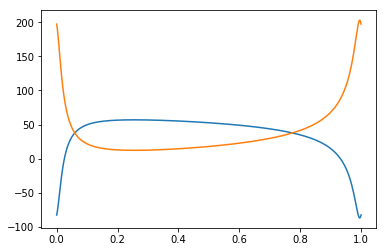

In [21]:
#Eq.8 L14
#Sigma Orionis A,B
#Schaefer et al. 2018
P_d = 143.2002
P_yr = P_d/365.256
T0 = 56597.638 + 2.4e6
T0 = Time(T0, format='jd')
T0 = T0.jyear
e = 0.77896
a = 0.0042860 
i = np.radians(56.378)
w = np.radians(199.83)
Omega = np.radians(6.878)

k1 = 72.03
lit_sigma_k1 = 0.25

k2 = 95.53
lit_sigma_k2 = 0.22

lit_gamma = 37.63
lit_sigma_gamma = 0.35


# Calculate velocity ratios
rat1 = k1/(k1+k2)
rat2 = k2/(k1+k2)

d_pc = 387.5
parallax = 1/d_pc

A, B, F, G, C, H = orbits.Thiele_Innes_from_Campbell(w, a, i, Omega, parallax=parallax)

num_obs = 1461
times = P_yr*np.arange(num_obs)/(num_obs-1)

#Set T0 to 0 here as times is 0 when the phase is 0 as per the equation immediaely above
ra_theo, dec_theo, radvel_theo = orbits.keplerian_xy_Thiele_Innes(times, A, B, F, G, 0, e, P_yr, C=C, H=H)
radvel_km_sec = orbits.AUyr2Kms(radvel_theo)

# Apply ratios to theoreticl velocity
radvel1 = rat1*radvel_km_sec
radvel2 = rat2*radvel_km_sec

Phase = times/P_yr

plt.plot(Phase, -radvel1+lit_gamma)
plt.plot(Phase, radvel2+lit_gamma)
plt.show()

Gamma from orbits routine: 36.337 +- 0.530
K1 from orbits routine: 64.853 +- 1.764
K2 from orbits routine: 98.866 +- 0.920


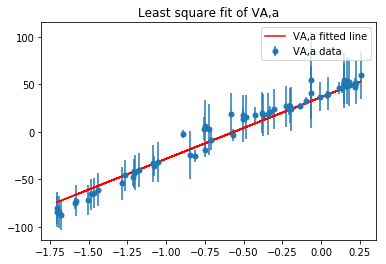

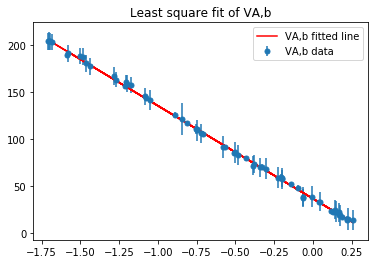

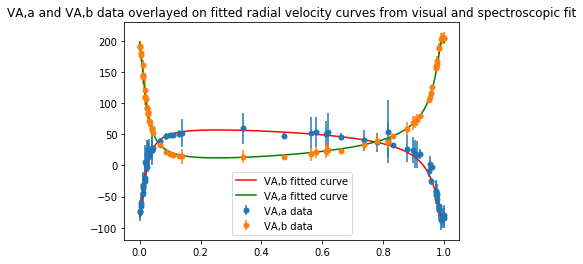

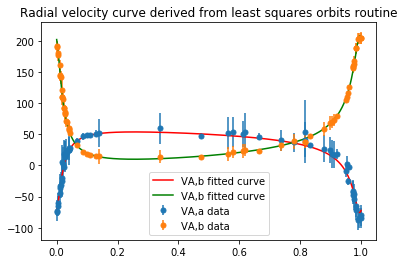

Fitted gamma sigma: 0.530
Paper gamma sigma: 0.350

Fitted k1 sigma: 1.764
Paper k1 sigma: 0.250

Fitted k2 sigma: 0.920
Paper k2 sigma: 0.220


In [22]:
def v_fraction(times, P, T, e, w):
    
    M = (2*np.pi/P)*(times-T)
    E = orbits.getE_parallel(M, e)
    v_frac = (np.cos(w)*np.cos(E)*(1-e**2)-np.sin(w)*np.sin(E)*np.sqrt(1-e**2))/(1-e*np.cos(E))
    return v_frac

#Sigma Orionis A,B
#Schaefer et al. 2018
P_d = 143.2002
P_yr = P_d/365.256
T0 = 56597.638 + 2.4e6
T0 = Time(T0, format='jd')
T0 = T0.jyear
e = 0.77896
a = 0.0042860 
i = np.radians(56.378)
w = np.radians(199.83)
Omega = np.radians(6.878)

datafile = "Orionis_rv.txt"
data = Table.read(datafile, format='ascii.commented_header')

times_HJD = data['HJD']
va = data['Va']
vb = data['Vb']
va_errs = data['Va_err']
vb_errs = data['Vb_err']

times_HJD = times_HJD + 2.4e6
times_HJD = Time(times_HJD, format='jd')
times_yr = times_HJD.jyear
times_remainder = (times_yr-T0)%P_yr
phase = times_remainder/P_yr

# Get x-values from times, i.e the value k is multiplied by at each time
f_t = v_fraction(times_yr, P_yr, T0, e, w)

gamma, k1, k2, sigma_list = orbits. rv_parameters_from_vt(f_t, f_t, va, vb, va_errs, vb_errs)

sigma_gamma = sigma_list[0]
sigma_k1 = sigma_list[1]
sigma_k2 = sigma_list[2]

print("Gamma from orbits routine: %0.3f +- %0.3f" %(gamma, sigma_gamma))
print("K1 from orbits routine: %0.3f +- %0.3f" %(k1, sigma_k1))
print("K2 from orbits routine: %0.3f +- %0.3f" %(k2, sigma_k2))

plt.title("Least square fit of VA,a")
plt.plot(f_t, k1*f_t + gamma, 'r', label='VA,a fitted line')
plt.errorbar(f_t, va, yerr=va_errs, fmt='o', label='VA,a data', markersize=5)
plt.legend()
plt.show()

plt.title("Least square fit of VA,b")
plt.plot(f_t, -k2*f_t + gamma, 'r', label='VA,b fitted line')
plt.errorbar(f_t, vb, yerr=vb_errs, fmt='o', label='VA,b data', markersize=5)
plt.legend()
plt.show()

plt.title("VA,a and VA,b data overlayed on fitted radial velocity curves from visual and spectroscopic fit")
plt.plot(Phase, -radvel1+lit_gamma, 'r', label='VA,b fitted curve')
plt.plot(Phase, radvel2+lit_gamma, 'g', label='VA,a fitted curve')
plt.errorbar(phase, va, yerr=va_errs, fmt='o', label='VA,a data', markersize=5)
plt.errorbar(phase, vb, yerr=vb_errs, fmt='o', label='VA,b data', markersize=5)
plt.legend()
plt.show()

num_obs_synth = 1491
times_synth = np.zeros(num_obs_synth)
times_synth = P_yr*np.arange(num_obs_synth)/(num_obs_synth-1)

f_t_synth = v_fraction(times_synth, P_yr, 0, e, w)
phase_synth = times_synth/P_yr

plt.title("Radial velocity curve derived from least squares orbits routine")
plt.plot(phase_synth, gamma + k1*f_t_synth, 'r', label='VA,b fitted curve')
plt.plot(phase_synth, gamma - k2*f_t_synth, 'g', label='VA,b fitted curve')
plt.errorbar(phase, va, yerr=va_errs, fmt='o', label='VA,a data', markersize=5)
plt.errorbar(phase, vb, yerr=vb_errs, fmt='o', label='VA,b data', markersize=5)
plt.legend()
plt.show()

print("Fitted gamma sigma: %0.3f" %(sigma_gamma))
print("Paper gamma sigma: %0.3f" %(lit_sigma_gamma))
print()
print("Fitted k1 sigma: %0.3f" %(sigma_k1))
print("Paper k1 sigma: %0.3f" %(lit_sigma_k1))
print()
print("Fitted k2 sigma: %0.3f" %(sigma_k2))
print("Paper k2 sigma: %0.3f" %(lit_sigma_k2))